Importing libraries

In [15]:
import pybammeis
import pybamm
import os
import re
import numpy as np
from gamry_parser import GamryParser, Impedance
import pandas as pd
import time as timer
import matplotlib.pyplot as plt
from scipy.fft import fft
import random
from scipy.optimize import minimize
from scipy.optimize import basinhopping
from scipy.interpolate import interp1d
import pyswarms as ps 
from pyswarms.single import GlobalBestPSO

Plotting experimental EIS data

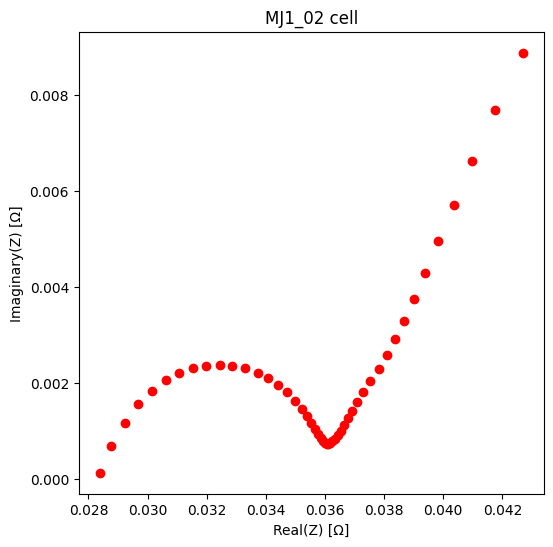

In [16]:
file = "/Users/synnemard/Desktop/lithium_ion/EIS data/MJ1_02.DTA"
# Information about the MJ1_02 cell: 
# ved BoL (Beginning of Life)
# ved ca. 45% SoC 
# ved 25 deg C

ca = Impedance(file)
ca.load(filename=file)

# process data header metadata to get start_time (not strictly necessary)
start_time = pd.Timestamp("{} {}".format(ca.header.get("DATE"), ca.header.get("TIME")))
    
# extract EIS curve
res = ca.get_curve_data()
res_reverse = res.iloc[::-1] #not necessary
df_mag = res_reverse['Zmod']
df_phz = res_reverse['Zphz']
df_real = res_reverse['Zreal']
df_imag= res_reverse['Zimag']
freq = res_reverse['Freq']

# excluding the values in the 4th quadrant: 
df_mag = df_mag[:49]
df_phz = df_phz[:49]
df_real = df_real[:49]
df_imag = df_imag[:49]
freq = freq[:49]

# Creating Nyquist plot
plt.figure(figsize=(6,6))
plt.scatter(df_real, -df_imag, color='red') 

# Labeling the plot
plt.xlabel('Real(Z) [Ω]')
plt.ylabel('Imaginary(Z) [Ω]')
plt.title('MJ1_02 cell')


#finner høyeste log frekvens 
x = np.log10(freq[22])

# Show plot
plt.show()


Generating EIS simulation

Assumptions:
- DFN model
- same parameters as I got from Amund
- input parameter SoC - 45% 
- at 25 degrees C
- using the numerical prebicgstab frequency domain method and also the time domain method

Defining Parameters

In [17]:
# OCV curves for the anode and cathode
# Simple math model for the individual electrode potentials as a function of the stoichiometry of Lithium
def MJ1_ocp_tanh_SiC(sto):
    x = sto
    p = np.array([ 1.20912055e+00,  5.62297420e+01, -1.11020020e-01, -2.53458213e-01, 4.92581391e+01,  1.22046522e-02,  4.73538620e-02,  1.79631246e+01, 1.75283209e-01,  1.88038929e-02,  3.03255334e+01,  4.66328034e-01])
    
    return (
            p[0] * pybamm.exp(-p[1] * x)
            + p[2]
            - p[3] * pybamm.tanh(p[4] * (x - p[5]))
            - p[6] * pybamm.tanh(p[7] * (x - p[8]))
            - p[9] * pybamm.tanh(p[10] * (x - p[11]))
        )

def MJ1_ocp_tanh_NMC(sto):
    x = sto
    p = np.array([ 0.74041974,  4.39107343,  0.03434767, 18.16841489,  0.53463176, 17.68283504, 14.59709162,  0.28835348, 17.58474971, 14.69911523,  0.28845641])

    return (
            -p[0] * x
            + p[1]
            - p[2] * pybamm.tanh(p[3] * (x - p[4]))
            - p[5] * pybamm.tanh(p[6] * (x - p[7]))
            + p[8] * pybamm.tanh(p[9] * (x - p[10]))
        )

# Parameters from literature
literature_params = {
    'Electrode height [m]': 0.059,
    'Electrode width [m]': 0.610*2, # Multiplying by two since the electrode has active material on both sides.
    'Lower voltage cut-off [V]': 2.5,
    'Upper voltage cut-off [V]': 4.5,
    'Nominal cell capacity [A.h]': 3.5,

    # From Table 3 in https://doi.org/10.1016/j.jpowsour.2018.11.043
    'Maximum concentration in negative electrode [mol.m-3]': 32418.5,
    'Negative particle radius [m]': 6.1e-06,
    'Negative electrode porosity': 0.216,
    'Negative electrode active material volume fraction': 0.7011854763922494,
    'Negative electrode conductivity [S.m-1]': 100.0,
    'Negative electrode diffusivity [m2.s-1]': 5e-14,
    'Negative electrode OCP [V]': MJ1_ocp_tanh_SiC,

    # 'Maximum concentration in positive electrode [mol.m-3]': 51081.15,
    'Positive particle radius [m]': 3.8e-06,
    'Positive electrode porosity': 0.171,
    'Positive electrode active material volume fraction': 0.7355902286855152,
    'Positive electrode conductivity [S.m-1]': 0.17,
    'Positive electrode diffusivity [m2.s-1]': 5e-13,
    'Positive electrode OCP [V]': MJ1_ocp_tanh_NMC,

    'Separator porosity': 0.45,

    # end of section 3 data
    
    # From Table A-9 and A-10 in https://doi.org/10.1016/j.jpowsour.2018.11.043
    'Negative current collector conductivity [S.m-1]': 5.9e7/(1+3.383e-3 * (298.15-293.15)), 
    'Negative current collector thickness [m]': 11e-06,
    'Negative current collector density [kg.m-3]': 8950.0,
    'Negative current collector specific heat capacity [J.kg-1.K-1]': 385.0,
    'Negative current collector thermal conductivity [W.m-1.K-1]': 398.0,
    'Negative electrode density [kg.m-3]': 2242.0,
    'Negative electrode specific heat capacity [J.kg-1.K-1]': 867.0,
    'Negative electrode thermal conductivity [W.m-1.K-1]': 1.04,
    'Negative electrode thickness [m]': 86.7e-6, # 86.7 in Sturm 2019, 85um in Heenan2020, 170um in NASA
    'Positive current collector conductivity [S.m-1]': 3.78e7/(1+4.290e-3 * (298.15-293.15)),
    'Positive current collector density [kg.m-3]': 2710.0,
    'Positive current collector specific heat capacity [J.kg-1.K-1]': 903.0,
    'Positive current collector thermal conductivity [W.m-1.K-1]': 238.0,
    'Positive current collector thickness [m]': 17.3e-06,
    'Positive electrode density [kg.m-3]': 4870.0,
    'Positive electrode specific heat capacity [J.kg-1.K-1]': 840.1,
    'Positive electrode thermal conductivity [W.m-1.K-1]': 1.58,
    'Positive electrode thickness [m]': 66.2e-6, #66.2um in Sturm2019, 72.5um in Heenan2020, 160um in NASA
    'Separator density [kg.m-3]': 1009.0,
    'Separator specific heat capacity [J.kg-1.K-1]': 1978.2,
    'Separator thermal conductivity [W.m-1.K-1]': 0.33,
    'Separator thickness [m]': 12e-06,
    # end of table data
    }

# Use default parameters from the Chen2020 publication
params = pybamm.ParameterValues("Chen2020")

# Overwrite parameters with our own
for parameter, value in literature_params.items():
    try:
        if params[parameter] != value: # Check if the parameter exists in 'params' and has a different value
            params[parameter] = value # Update 'params' with the new value from 'literature_params'
    except KeyError as e: # This block handles the case where the 'parameter' is not in 'params'
        print(f"Parameter {parameter} not part of default. Skipping.")

# Changing state of charge SOC
z = 0.45

x0, x100, y100, y0 = pybamm.lithium_ion.get_min_max_stoichiometries(params)
x = x0 + z * (x100 - x0)
y = y0 - z * (y0 - y100)
c_n_max = params["Maximum concentration in negative electrode [mol.m-3]"]
c_p_max = params["Maximum concentration in positive electrode [mol.m-3]"]

params.update(
    {
        "Initial concentration in negative electrode [mol.m-3]": x * c_n_max,
        "Initial concentration in positive electrode [mol.m-3]": y * c_p_max,
    }
)

# params['Initial temperature [K]'] = ambient temperature = 25 degrees

# Choosing the same frequency range as in the experimental plot. 
# x is ish equal to 2.8
frequencies = np.logspace(-2, 2.8, 49)




Updating charge transfer resistance (by changing (increasing) exchange current density)

In [4]:
'''
j0_ref1 = 5
C_dl1 = 0.5

params.update(
    {"Positive electrode reference exchange-current density [A.m-2]": j0_ref1, #pybamm.InputParameter("j0_ref"),
    "Positive electrode double-layer capacity [F.m-2]": C_dl1   #pybamm.InputParameter("C_dl")
    },
    check_already_exists=False,
)

# exchange current density at the graphite anode in the LGM50 cell
def graphite_LGM50_electrolyte_exchange_current_density_Chen2020(
    c_e, c_s_surf, c_s_max, T
):
    """
    Exchange-current density for Butler-Volmer reactions between graphite and LiPF6 in
    EC:DMC.

    References
    ----------
    .. [1] Chang-Hui Chen, Ferran Brosa Planella, Kieran O’Regan, Dominika Gastol, W.
    Dhammika Widanage, and Emma Kendrick. "Development of Experimental Techniques for
    Parameterization of Multi-scale Lithium-ion Battery Models." Journal of the
    Electrochemical Society 167 (2020): 080534.

    Parameters
    ----------
    c_e : :class:`pybamm.Symbol`
        Electrolyte concentration [mol.m-3]
    c_s_surf : :class:`pybamm.Symbol`
        Particle concentration [mol.m-3]
    c_s_max : :class:`pybamm.Symbol`
        Maximum particle concentration [mol.m-3]
    T : :class:`pybamm.Symbol`
        Temperature [K]

    Returns
    -------
    :class:`pybamm.Symbol`
        Exchange-current density [A.m-2]
    """
    m_ref = 6.48e-7  # (A/m2)(m3/mol)**1.5 - includes ref concentrations
    E_r = 35000
    arrhenius = np.exp(E_r / pybamm.constants.R * (1 / 298.15 - 1 / T))

    return (m_ref * arrhenius * c_e**0.5 * c_s_surf**0.5 * (c_s_max - c_s_surf) ** 0.5)*1 #multiplied with 2 to decrease charge transfer resistance


# Exchange current density at the cathode, found from EIS example at pybammeis 
def j0(c_e, c_s_surf, c_s_max, T):
    #j0_ref = j0_ref1
    j0_ref = pybamm.Parameter("Positive electrode reference exchange-current density [A.m-2]")
    c_e_init = pybamm.Parameter("Initial concentration in electrolyte [mol.m-3]")

    return (
        j0_ref
        * (c_e / c_e_init) ** 0.5
        * (c_s_surf / c_s_max) ** 0.5
        * (1 - c_s_surf / c_s_max) ** 0.5
    )

params.update(
    {
        "Positive electrode exchange-current density [A.m-2]": j0,
        "Negative electrode exchange-current density [A.m-2]": graphite_LGM50_electrolyte_exchange_current_density_Chen2020, 
    },
    check_already_exists=False,
)

'''

'\nj0_ref1 = 5\nC_dl1 = 0.5\n\nparams.update(\n    {"Positive electrode reference exchange-current density [A.m-2]": j0_ref1, #pybamm.InputParameter("j0_ref"),\n    "Positive electrode double-layer capacity [F.m-2]": C_dl1   #pybamm.InputParameter("C_dl")\n    },\n    check_already_exists=False,\n)\n\n# exchange current density at the graphite anode in the LGM50 cell\ndef graphite_LGM50_electrolyte_exchange_current_density_Chen2020(\n    c_e, c_s_surf, c_s_max, T\n):\n    """\n    Exchange-current density for Butler-Volmer reactions between graphite and LiPF6 in\n    EC:DMC.\n\n    References\n    ----------\n    .. [1] Chang-Hui Chen, Ferran Brosa Planella, Kieran O’Regan, Dominika Gastol, W.\n    Dhammika Widanage, and Emma Kendrick. "Development of Experimental Techniques for\n    Parameterization of Multi-scale Lithium-ion Battery Models." Journal of the\n    Electrochemical Society 167 (2020): 080534.\n\n    Parameters\n    ----------\n    c_e : :class:`pybamm.Symbol`\n        Ele

Updating parameters I think is incorrect: 

- overflateareal mellom elektrode og elektrolytt - surface area between electrode and electrolyte
Instead: The electrode thicknesses or adjust the Bruggeman coefficient for the electrolyte (reduces ion transport which lowers interaction between the electrolyte and electrode)

- Electrolyte conductivity 

- (feil porositet)

In [18]:
model1 = pybamm.lithium_ion.DFN(options={"surface form": "differential"})
dic1 = model1.get_parameter_info() #49
model2 = pybamm.lithium_ion.DFN() 
dic2 = model2.get_parameter_info() #47

diff_keys = set(dic1.keys()) - set(dic2.keys())
print(diff_keys)

# Her ser vi at den positive og negative electrode double-layer capacity kan bli endret!

{'Positive electrode double-layer capacity [F.m-2]', 'Negative electrode double-layer capacity [F.m-2]'}


In [6]:
'''

# har fjernet nominal cell capacity og Bruggeman coefficient foreløpig 
# har lagt til positive electrode reference exchange-current density j0_ref 

initial_params = [
    float(params['Negative electrode thickness [m]']), 
    #float(params['Negative electrode Bruggeman coefficient (electrolyte)']),
    # float(params['Nominal cell capacity [A.h]']),  
    float(params['Separator thickness [m]']),
    float(params['Negative electrode double-layer capacity [F.m-2]']), 
    float(params['Positive electrode double-layer capacity [F.m-2]']), 
    float(params['Electrode width [m]']), 
    float(params["Positive electrode reference exchange-current density [A.m-2]"]), 
    ]

print(initial_params)


'''

'\n\n# har fjernet nominal cell capacity og Bruggeman coefficient foreløpig \n# har lagt til positive electrode reference exchange-current density j0_ref \n\ninitial_params = [\n    float(params[\'Negative electrode thickness [m]\']), \n    #float(params[\'Negative electrode Bruggeman coefficient (electrolyte)\']),\n    # float(params[\'Nominal cell capacity [A.h]\']),  \n    float(params[\'Separator thickness [m]\']),\n    float(params[\'Negative electrode double-layer capacity [F.m-2]\']), \n    float(params[\'Positive electrode double-layer capacity [F.m-2]\']), \n    float(params[\'Electrode width [m]\']), \n    float(params["Positive electrode reference exchange-current density [A.m-2]"]), \n    ]\n\nprint(initial_params)\n\n\n'

Finding the sum of squared difference between the simulated model and the experimental data

In [7]:
'''
real_exp = np.array(df_real)
imag_exp = np.array(df_imag)

#options={"surface form": "differential"}

def Z_sim(frequencies, upt_par):
  model = pybamm.lithium_ion.DFN(options={"surface form": "differential"})
  #options={"surface form": "differential"}
  params.update(
    {'Negative electrode thickness [m]': upt_par[0], 
     #'Negative electrode Bruggeman coefficient (electrolyte)': upt_par[1], 
     #'Positive electrode Bruggeman coefficient (electrolyte)': upt_par[1], 
     #'Separator Bruggeman coefficient (electrolyte)': upt_par[1], 
     #'Nominal cell capacity [A.h]': upt_par[2], 
     'Separator thickness [m]': upt_par[1], 
     'Negative electrode double-layer capacity [F.m-2]': upt_par[2], 
     'Positive electrode double-layer capacity [F.m-2]': upt_par[3], 
     'Electrode width [m]': upt_par[4], 
     'Positive electrode reference exchange-current density [A.m-2]': upt_par[5]
     })
  
  def j0(c_e, c_s_surf, c_s_max, T):
    #j0_ref = j0_ref1
    j0_ref = pybamm.Parameter("Positive electrode reference exchange-current density [A.m-2]")
    c_e_init = pybamm.Parameter("Initial concentration in electrolyte [mol.m-3]")

    return (
        j0_ref
        * (c_e / c_e_init) ** 0.5
        * (c_s_surf / c_s_max) ** 0.5
        * (1 - c_s_surf / c_s_max) ** 0.5
    )
  params.update(
    {'Positive electrode exchange-current density [A.m-2]': j0})
  
  eis_sim = pybammeis.EISSimulation(model, parameter_values=params)
  z_sim = eis_sim.solve(frequencies, method = "prebicgstab")
  return z_sim 


def diff_function(upt_par, frequencies, real_exp, imag_exp): 
  imp_sim = Z_sim(frequencies, upt_par)
  real_sim = np.real(imp_sim)
  imag_sim = np.imag(imp_sim)

  real_diff = real_sim - real_exp 
  imag_diff = imag_sim - imag_exp 

  #the total sum of squared differences (magnitude, absolute value, of the complex differences)
  sum_square_diff = np.sum(real_diff**2 + imag_diff**2)
  return sum_square_diff

#diff_function(initial_params, frequencies, real_exp, imag_exp)

# to pass the additional arguments
# args = (frequencies, real_exp, imag_exp)
def wrapped_diff_function(upt_par):
  return np.array([diff_function(par, frequencies, real_exp, imag_exp) for par in upt_par])

'''

'\nreal_exp = np.array(df_real)\nimag_exp = np.array(df_imag)\n\n#options={"surface form": "differential"}\n\ndef Z_sim(frequencies, upt_par):\n  model = pybamm.lithium_ion.DFN(options={"surface form": "differential"})\n  #options={"surface form": "differential"}\n  params.update(\n    {\'Negative electrode thickness [m]\': upt_par[0], \n     #\'Negative electrode Bruggeman coefficient (electrolyte)\': upt_par[1], \n     #\'Positive electrode Bruggeman coefficient (electrolyte)\': upt_par[1], \n     #\'Separator Bruggeman coefficient (electrolyte)\': upt_par[1], \n     #\'Nominal cell capacity [A.h]\': upt_par[2], \n     \'Separator thickness [m]\': upt_par[1], \n     \'Negative electrode double-layer capacity [F.m-2]\': upt_par[2], \n     \'Positive electrode double-layer capacity [F.m-2]\': upt_par[3], \n     \'Electrode width [m]\': upt_par[4], \n     \'Positive electrode reference exchange-current density [A.m-2]\': upt_par[5]\n     })\n  \n  def j0(c_e, c_s_surf, c_s_max, T):\n   

Particle Swarm Optimization 

In [8]:
'''

lower_bounds = [50e-6,5e-6,0.01,0.01, 40e-3, 0] #, -100
upper_bounds = [300e-6,50e-6,0.2,0.2, 2, 10] #, 100
bounds = (lower_bounds, upper_bounds)

n_dim = 6 # changing 6 parameters

options = {'c1': 0.5,      # Cognitive parameter (influence of personal best)
    'c2': 0.3,      # Social parameter (influence of global best)
    'w': 0.9,       # Inertia parameter (how much particles retain velocity)
    }

optimizer = ps.single.GlobalBestPSO(n_particles=5, dimensions=n_dim, options=options, bounds=bounds)

best_cost, best_params = optimizer.optimize(wrapped_diff_function, iters=2)

print(initial_params)
print("Optimized Parameters:", best_params)
print("Best Cost:", best_cost)

'''

'\n\nlower_bounds = [50e-6,5e-6,0.01,0.01, 40e-3, 0] #, -100\nupper_bounds = [300e-6,50e-6,0.2,0.2, 2, 10] #, 100\nbounds = (lower_bounds, upper_bounds)\n\nn_dim = 6 # changing 6 parameters\n\noptions = {\'c1\': 0.5,      # Cognitive parameter (influence of personal best)\n    \'c2\': 0.3,      # Social parameter (influence of global best)\n    \'w\': 0.9,       # Inertia parameter (how much particles retain velocity)\n    }\n\noptimizer = ps.single.GlobalBestPSO(n_particles=5, dimensions=n_dim, options=options, bounds=bounds)\n\nbest_cost, best_params = optimizer.optimize(wrapped_diff_function, iters=2)\n\nprint(initial_params)\nprint("Optimized Parameters:", best_params)\nprint("Best Cost:", best_cost)\n\n'

Udating parameters based on the "best parameters" from "best cost"

In [9]:
'''
params.update(
    { 'Negative electrode thickness [m]': best_params[0],
      #'Negative electrode Bruggeman coefficient (electrolyte)': opt_params[1],
      #'Positive electrode Bruggeman coefficient (electrolyte)': opt_params[1],
      #'Separator Bruggeman coefficient (electrolyte)': opt_params[1], 
      #'Nominal cell capacity [A.h]': opt_params[2], 
      'Separator thickness [m]': best_params[1], 
      'Negative electrode double-layer capacity [F.m-2]': best_params[2], 
      'Positive electrode double-layer capacity [F.m-2]': best_params[3],
      'Electrode width [m]': best_params[4], 
      "Positive electrode reference exchange-current density [A.m-2]": best_params[5]
      
     
     }
    )

'''

'\nparams.update(\n    { \'Negative electrode thickness [m]\': best_params[0],\n      #\'Negative electrode Bruggeman coefficient (electrolyte)\': opt_params[1],\n      #\'Positive electrode Bruggeman coefficient (electrolyte)\': opt_params[1],\n      #\'Separator Bruggeman coefficient (electrolyte)\': opt_params[1], \n      #\'Nominal cell capacity [A.h]\': opt_params[2], \n      \'Separator thickness [m]\': best_params[1], \n      \'Negative electrode double-layer capacity [F.m-2]\': best_params[2], \n      \'Positive electrode double-layer capacity [F.m-2]\': best_params[3],\n      \'Electrode width [m]\': best_params[4], \n      "Positive electrode reference exchange-current density [A.m-2]": best_params[5]\n      \n     \n     }\n    )\n\n'

HUGE change in functions

Exchange current densities

In [27]:

def nmc_LGM50_electrolyte_exchange_current_density_Chen2020(c_e, c_s_surf, c_s_max, T):
    m_ref = 3.42e-6  # (A/m2)(m3/mol)**1.5 - includes ref concentrations
    E_r = 17800
    arrhenius = np.exp(E_r / pybamm.constants.R * (1 / 298.15 - 1 / T))

    return (m_ref * arrhenius * c_e**0.5 * c_s_surf**0.5 * (c_s_max - c_s_surf) ** 0.5)*1e3 #Multiplying by 1000



def graphite_LGM50_electrolyte_exchange_current_density_Chen2020(
    c_e, c_s_surf, c_s_max, T
):
    m_ref = 6.48e-7  # (A/m2)(m3/mol)**1.5 - includes ref concentrations
    E_r = 35000
    arrhenius = np.exp(E_r / pybamm.constants.R * (1 / 298.15 - 1 / T))

    return (m_ref * arrhenius * c_e**0.5 * c_s_surf**0.5 * (c_s_max - c_s_surf) ** 0.5)*1e3 #Multiplying by 1000

params.update(
    {
        "Positive electrode exchange-current density [A.m-2]": nmc_LGM50_electrolyte_exchange_current_density_Chen2020,
        "Negative electrode exchange-current density [A.m-2]": graphite_LGM50_electrolyte_exchange_current_density_Chen2020, 
    },
    check_already_exists=False,
)



ELectrolyte conductivity - increase -> decrease semicircle height

In [28]:
def electrolyte_conductivity_Nyman2008(c_e, T):
    
    sigma_e = (
        0.1297 * (c_e / 1000) ** 3 - 2.51 * (c_e / 1000) ** 1.5 + 3.329 * (c_e / 1000)
    )

    # Nyman et al. (2008) does not provide temperature dependence

    return (sigma_e)

params.update(
    {
        "Electrolyte conductivity [S.m-1]": electrolyte_conductivity_Nyman2008,
    },
    check_already_exists=False,

)

ELectrolyte diffusivity - increase -> decrease semicircle width 

In [29]:
def electrolyte_diffusivity_Nyman2008(c_e, T):
    D_c_e = 8.794e-11 * (c_e / 1000) ** 2 - 3.972e-10 * (c_e / 1000) + 4.862e-10

    # Nyman et al. (2008) does not provide temperature dependence

    return (D_c_e)

params.update(
    {
        "Electrolyte diffusivity [m2.s-1]": electrolyte_diffusivity_Nyman2008, 
    },
    check_already_exists=False,

)

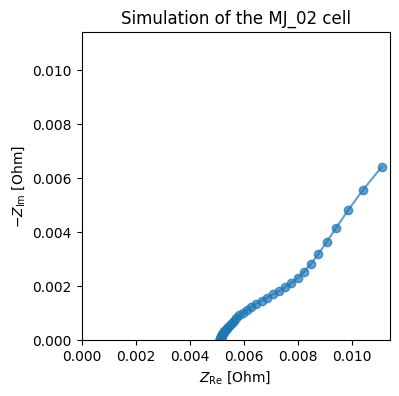

[[3376.34946456 3376.34946456 3376.34946456 ... 3376.34946456
  3376.34946456 3376.34946456]
 [3376.34946456 3376.34946456 3376.34946456 ... 3376.34946456
  3376.34946456 3376.34946456]
 [3376.34946456 3376.34946456 3376.34946456 ... 3376.34946456
  3376.34946456 3376.34946456]
 ...
 [3376.34946456 3376.34946456 3376.34946456 ... 3376.34946456
  3376.34946456 3376.34946456]
 [3376.34946456 3376.34946456 3376.34946456 ... 3376.34946456
  3376.34946456 3376.34946456]
 [3376.34946456 3376.34946456 3376.34946456 ... 3376.34946456
  3376.34946456 3376.34946456]]


<Figure size 640x480 with 0 Axes>

interactive(children=(FloatSlider(value=0.0, description='t', max=120.0, step=1.2), Output()), _dom_classes=('…

In [30]:
model = pybamm.lithium_ion.DFN()
#options={"surface form": "differential"}

# Create simulation
eis_sim = pybammeis.EISSimulation(model, parameter_values=params)

sim_f = eis_sim.solve(frequencies, method = "prebicgstab")

# Plotting the simulation (from frequency domain)
fig, ax = plt.subplots(figsize=(4, 4)) 
pybammeis.nyquist_plot(sim_f, ax=ax, linestyle="-", label=f"Simulation", alpha=0.7
    )
#ax.set_xlim(0.0475, 0.0550) 
#ax.set_ylim(0, 0.008)

#plt.legend()
plt.title('Simulation of the MJ_02 cell')
plt.show()
plt.clf()

sim = pybamm.Simulation(model, parameter_values=params)
t_eval = np.arange(0, 121, 1)
sim.solve(t_eval = t_eval)
print(sim.solution['Positive electrode exchange current density [A.m-2]'].entries)
sim.plot([ "Current [A]", "Voltage [V]",'Positive electrode exchange current density [A.m-2]']) 


HUGE code 

In [109]:
# Function to convert dictionary to list
def dict_to_list(c_elem):
    return list(c_elem.values())

# Function to convert list back to dictionary
def list_to_dict(c_elem, optimized_values):
    keys = list(c_elem.keys())
    return dict(zip(keys, optimized_values))

e_height = 0.059    #params['Electrode height [m]']
e_width = 0.9033043292355315      #params['Electrode width [m]']
e_A = e_height*e_width

s_thick = 1.0598531461526225e-05 #params['Separator thickness [m]']
anode_thick = 0.00019850124472796743 #params['Negative electrode thickness [m]']
cathode_thick = 6.62e-05 #params['Positive electrode thickness [m]']

# For small overpotentials and assuming a symmetrical charge transfer process, 
#i_0 = (R*T)/(n*F*Rct) 
#From Butler-Volmer! 
i_0  = 0.0257 * 0.004924506328399464 #from Randles circuit 

# Diffusivity from the Warburg coefficient A: 
# D = ((R*T)/(n*F*area*A))**2
# D = ((8.314*298)/(1*96485*area*.002162371149615444))**2


# parameters I want to change to optimize the graph: 
p = {
    #Capacity - analog to Cdl/CPE in the Randles circuit 
    'Negative electrode double-layer capacity [F.m-2]': 0.320907453/e_A, #constant or function? 
    'Positive electrode double-layer capacity [F.m-2]': 0.320907453/e_A, #constant or function? 

    #Exchange current density - analog to Rct in the Randles circuit through the Butler-Volmer 
    #"Positive electrode reference exchange-current density [A.m-2]": , #do not think this is needed
    "Positive electrode exchange-current density [A.m-2]": i_0, #function
    "Negative electrode exchange-current density [A.m-2]": i_0, #function 

    #Omic resistance - analog to Rel in the Randles circuit? 
    "Electrolyte conductivity [S.m-1]": 1/(s_thick*0.013217154712578262), #function 
    # 
    "Negative electrode conductivity [S.m-1]": 1/(anode_thick*0.013217154712578262), #function 
    "Positive electrode conductivity [S.m-1]": 1/(cathode_thick*0.013217154712578262), #function

    #Mass transfer resistance - analog to W in the Randles circuit? 
    "Electrolyte diffusivity [m2.s-1]": ((8.314*298)/(1*96485*e_height*s_thick*.002162371149615444))**2, #function
    "Negative particle diffusivity [m2.s-1]": ((8.314*298)/(1*96485*e_height*anode_thick*.002162371149615444))**2,
    "Positive particle diffusivity [m2.s-1]": ((8.314*298)/(1*96485*e_height*cathode_thick*.002162371149615444))**2  
     }

print(p)

init_params = dict_to_list(p)


def Z_sim(frequencies, upt_par):
  model = pybamm.lithium_ion.DFN(options={"surface form": "differential"})
  params.update(
    {'Negative electrode double-layer capacity [F.m-2]': upt_par[0], 
     'Positive electrode double-layer capacity [F.m-2]': upt_par[1], 

     "Positive electrode exchange-current density [A.m-2]": upt_par[2], 
     "Negative electrode exchange-current density [A.m-2]": upt_par[3], 

     "Electrolyte conductivity [S.m-1]": upt_par[4], 
     "Negative electrode conductivity [S.m-1]": upt_par[5], 
     "Positive electrode conductivity [S.m-1]": upt_par[6], 

     "Electrolyte diffusivity [m2.s-1]": upt_par[7],
     "Negative particle diffusivity [m2.s-1]": upt_par[8], 
     "Positive particle diffusivity [m2.s-1]": upt_par[9]
     })
  eis_sim = pybammeis.EISSimulation(model, parameter_values=params)
  z_sim = eis_sim.solve(frequencies, method = "prebicgstab")
  return z_sim 


real_exp = np.array(df_real)
imag_exp = np.array(df_imag)

def diff_function(upt_par, frequencies, real_exp, imag_exp): 
  imp_sim = Z_sim(frequencies, upt_par)
  real_sim = np.real(imp_sim)
  imag_sim = np.imag(imp_sim)

  real_diff = real_sim - real_exp 
  imag_diff = imag_sim - imag_exp 

  #the total sum of squared differences (magnitude, absolute value, of the complex differences)
  sum_square_diff = np.sum(real_diff**2 + imag_diff**2)
  return sum_square_diff

#diff_function(initial_params, frequencies, real_exp, imag_exp)

# to pass the additional arguments
# args = (frequencies, real_exp, imag_exp)
def wrapped_diff_function(upt_par):
  return np.array([diff_function(par, frequencies, real_exp, imag_exp) for par in upt_par])

#lower_bounds = [50e-6,5e-6,0.01,0.01, 40e-3, 0] #, -100
#upper_bounds = [300e-6,50e-6,0.2,0.2, 2, 10] #, 100
#bounds = (lower_bounds, upper_bounds)

n_dim = 10 # changing 10 parameters

options = {'c1': 0.5,      # Cognitive parameter (influence of personal best)
    'c2': 0.3,      # Social parameter (influence of global best)
    'w': 0.9,       # Inertia parameter (how much particles retain velocity)
    }

optimizer = ps.single.GlobalBestPSO(n_particles=2, dimensions=n_dim, options=options)  #, bounds=bounds)

best_cost, best_params = optimizer.optimize(wrapped_diff_function, iters=2)

dic_best_params = list_to_dict(p, best_params)
print("Optimized Parameters:", dic_best_params)
print("Best Cost:", best_cost)


2024-10-11 13:57:03,063 - pyswarms.single.global_best - INFO - Optimize for 2 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


{'Negative electrode double-layer capacity [F.m-2]': 6.02134761989294, 'Positive electrode double-layer capacity [F.m-2]': 6.02134761989294, 'Positive electrode exchange-current density [A.m-2]': 0.00012655981263986623, 'Negative electrode exchange-current density [A.m-2]': 0.00012655981263986623, 'Electrolyte conductivity [S.m-1]': 7138654.002652527, 'Negative electrode conductivity [S.m-1]': 381152.51692123554, 'Positive electrode conductivity [S.m-1]': 1142888.9583091077, 'Electrolyte diffusivity [m2.s-1]': 360642644891216.9, 'Negative particle diffusivity [m2.s-1]': 1028115714520.4261, 'Positive particle diffusivity [m2.s-1]': 9243841436422.555}


pyswarms.single.global_best: 100%|██████████|2/2, best_cost=0.0134
2024-10-11 13:57:07,169 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.013443493661533806, best pos: [1.14385342 0.76493076 0.75685402 0.67768708 0.43000437 0.62657955
 1.00037844 0.29808744 0.50588699 1.05195403]


Optimized Parameters: {'Negative electrode double-layer capacity [F.m-2]': 1.1438534153341533, 'Positive electrode double-layer capacity [F.m-2]': 0.7649307599214624, 'Positive electrode exchange-current density [A.m-2]': 0.7568540215458233, 'Negative electrode exchange-current density [A.m-2]': 0.6776870755582889, 'Electrolyte conductivity [S.m-1]': 0.4300043678976333, 'Negative electrode conductivity [S.m-1]': 0.6265795540863306, 'Positive electrode conductivity [S.m-1]': 1.0003784437849954, 'Electrolyte diffusivity [m2.s-1]': 0.2980874434343925, 'Negative particle diffusivity [m2.s-1]': 0.5058869899789777, 'Positive particle diffusivity [m2.s-1]': 1.0519540301650525}
Best Cost: 0.013443493661533806


The general model 

In [110]:
model = pybamm.lithium_ion.DFN(options={"surface form": "differential"})
#options={"surface form": "differential"}

# Create simulation
eis_sim = pybammeis.EISSimulation(model, parameter_values=params)

#model.print_parameter_info()
#params.search('thickness')


Model solved in the frequency domain (with prebicgstab method)

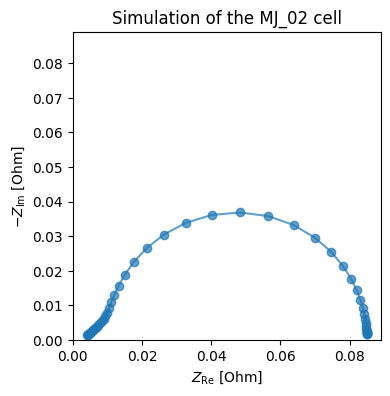

In [111]:
sim_f = eis_sim.solve(frequencies, method = "prebicgstab")

# Plotting the simulation (from frequency domain)
fig, ax = plt.subplots(figsize=(4, 4)) 
pybammeis.nyquist_plot(sim_f, ax=ax, linestyle="-", label=f"Simulation", alpha=0.7
    )

#ax.set_xlim(0.0475, 0.0550) 
#ax.set_ylim(0, 0.008)

#plt.legend()
plt.title('Simulation of the MJ_02 cell')
plt.show() 

Model solved in the time domain (with sinus current)

In [72]:
'''
# Time domain
I_app = 0.07 # 10% av output current
number_of_periods = 1 
samples_per_period = 50
# Ser ut som man kan putte inn number of periods og samples per period også
# Ann_Mari snakket om at jeg bare trengte én periode og 50 samples per periode. 


def current_function(t):
    return I_app * pybamm.sin(2 * np.pi * pybamm.InputParameter("Frequency [Hz]") * t)


params["Current function [A]"] = current_function
# Oppdaterer parametrene til å ha en current function!! 


sim_t = pybamm.Simulation(model, parameter_values=params)
# Så simuleringen avhenger av modellen, parametermodellen, osv. 

impedances_time = []
for frequency in frequencies:
    # Solve
    period = 1 / frequency
    dt = period / samples_per_period
    t_eval = np.array(range(0, samples_per_period * number_of_periods)) * dt
    sol = sim_t.solve(t_eval, inputs={"Frequency [Hz]": frequency})
    # Extract final two periods of the solution
    time = sol["Time [s]"].entries[-5 * samples_per_period :]
    current = sol["Current [A]"].entries[-5 * samples_per_period :]
    voltage = sol["Voltage [V]"].entries[-5 * samples_per_period :]
    # Vet ikke hvorfor man starter listene så langt bak? 
    # FFT - Fourier transform av current og voltage! 
    current_fft = fft(current)
    voltage_fft = fft(voltage)
    # Get index of first harmonic - the fundamental frequency itself (representing the primary sine wave)
    # Higher harmonics are multiples of this base frequency and contribute to the overall wave shape. 
    # Since they only find the first harmonic - are they assuming that the response is pseudo-linear? 
    idx = np.argmax(np.abs(current_fft))
    impedance = -voltage_fft[idx] / current_fft[idx]
    impedances_time.append(impedance)


# Plotting the simulation (from the time domain)
fig, ax = plt.subplots(figsize=(4, 4)) 
pybammeis.nyquist_plot(impedances_time, ax=ax, linestyle="-", label=f"Simulation", alpha=0.7
    )
#ax.set_xlim(0.0475, 0.0550) 
#ax.set_ylim(0, 0.008)

#plt.legend()
plt.title('Simulation of the MJ_02 cell')
plt.show() 

'''

'\n# Time domain\nI_app = 0.07 # 10% av output current\nnumber_of_periods = 1 \nsamples_per_period = 50\n# Ser ut som man kan putte inn number of periods og samples per period også\n# Ann_Mari snakket om at jeg bare trengte én periode og 50 samples per periode. \n\n\ndef current_function(t):\n    return I_app * pybamm.sin(2 * np.pi * pybamm.InputParameter("Frequency [Hz]") * t)\n\n\nparams["Current function [A]"] = current_function\n# Oppdaterer parametrene til å ha en current function!! \n\n\nsim_t = pybamm.Simulation(model, parameter_values=params)\n# Så simuleringen avhenger av modellen, parametermodellen, osv. \n\nimpedances_time = []\nfor frequency in frequencies:\n    # Solve\n    period = 1 / frequency\n    dt = period / samples_per_period\n    t_eval = np.array(range(0, samples_per_period * number_of_periods)) * dt\n    sol = sim_t.solve(t_eval, inputs={"Frequency [Hz]": frequency})\n    # Extract final two periods of the solution\n    time = sol["Time [s]"].entries[-5 * sample

Optimization of ECM parameters

In [58]:
# Randles components parameters 
c_elem = {
    "R_el1": 0.013217154712578262,  # Electrolyte resistance (Ohms)
    "R_ct1": 0.004924506328399464,  # Charge transfer resistance (Ohms)
    "C_dl1": 0.320907453,  # Double layer capacitance (Farads)
    "Q1" : 0.6392422479332148, 
    "alpha1": 0.7466, 
    "A1": 0.002162371149615444,     # Warburg coefficient
    "a_w1": 0.5854586714053394, 
    "L1": 2.510395438687557e-07,      # Inductance (H)

    #"R_el2": 0.013217157765118502,  # Electrolyte resistance (Ohms)
    "R_ct2": 0.004642735798131991,  # Charge transfer resistance (Ohms)
    "C_dl2": 0.320907453,  # Double layer capacitance (Farads)
    "Q2" : 2.311905447504065, 
    "alpha2": 0.7679316361779691, 
    "A2": 0.027250693541684783,     # Warburg coefficient
    "a_w2": 0.74, 
    #"L2": 2.586983862659044e-07      # Inductance (H)
    }


# Function to convert dictionary to list
def dict_to_list(c_elem):
    return list(c_elem.values())

# Function to convert list back to dictionary
def list_to_dict(c_elem, optimized_values):
    keys = list(c_elem.keys())
    return dict(zip(keys, optimized_values))


In [108]:

# Angular frequencies
ang_freq = 2*np.pi*frequencies

# Define Warburg impedance
def w_imp(omega, A):
    return A / np.sqrt(1j*omega)

def wni_imp(omega, A, a_w): # Non-Ideal 
    return A /(1j * omega)** a_w

# Define Capacitance impedance
def c_imp(omega, C): 
    return 1/(1j*omega*C)

# CPE for non-ideal behaviour
def cpe_imp(omega, Q, alpha): 
    return 1/(Q*(1j*omega)**alpha)

# Define Inductance impedance
def i_imp(omega, L): 
    return 1j*omega*L

# function for difference between the ECM model and the experimental values
def diff_func(comp, exp_real, exp_imag): 

    # Update c_elem dictionary from the flat parameter list (comp)
    c_elem_up = list_to_dict(c_elem, comp)

    Z_W1 = wni_imp(ang_freq, c_elem_up["A1"], c_elem_up["a_w1"])
    Z_cdl1 = cpe_imp(ang_freq, c_elem_up["Q1"], c_elem_up["alpha1"])
    Z_L1 = i_imp(ang_freq, c_elem_up["L1"])

    Z_W2 = wni_imp(ang_freq, c_elem_up["A2"], c_elem_up["a_w2"])
    Z_cdl2 = cpe_imp(ang_freq, c_elem_up["Q2"], c_elem_up["alpha2"])
    Z_L2 = i_imp(ang_freq, c_elem_up["L2"])

    Z1 = Z_L1 + c_elem_up["R_el1"] + 1/(1/(c_elem_up["R_ct1"] + Z_W1) + 1/Z_cdl1)
    #Z2 = Z_L2 + c_elem_up["R_el2"] + 1/(1/(c_elem_up["R_ct2"]) + 1/Z_cdl2)
    Z2 =  1/(1/(c_elem_up["R_ct2"]) + 1/Z_cdl2)
    Z = Z1 + Z2

    diff_real = Z.real - exp_real 
    diff_imag = Z.imag - exp_imag 
    sum_square_diff = np.sum(diff_real**2 + diff_imag**2)
    return sum_square_diff

# Convert initial dictionary to list for optimization
initial_elems = dict_to_list(c_elem)

options = {
    'maxiter': 10000,    # Maximum number of iterations
    'ftol': 1e-10,       # Function value tolerance
    'disp': True         # Display convergence messages
}

# Minimize the difference function (optimize parameters)
opt = minimize(diff_func, initial_elems, args=(df_real, df_imag), method='TNC', options=options)

# Convert the optimized list back to dictionary
opt_elems = list_to_dict(c_elem, opt.x)

# Print the optimized elements
print("Optimized elements:", opt_elems)

# Print the difference after optimization
print("Final sum of squared difference:", diff_func(opt.x, df_real, df_imag))


  NIT   NF   F                       GTG
    0    1  8.563003766407173E-03   4.98567152E+02
tnc: fscale = 0.0447827
    1    5  9.152915558378307E-04   4.22325285E+04
    2   10  8.409696550426754E-06   3.81241176E+02
    3   13  3.042985862922541E-06   1.31172106E-01
tnc: fscale = 2.76108
    4   18  2.919013976558032E-06   8.11967793E-05
tnc: fscale = 110.755
    5   23  2.799913216041875E-06   1.03929019E-05
    6   33  1.603146988420115E-06   3.72232411E+01
tnc: fscale = 0.163905
    7   38  7.857849580697622E-07   1.23065261E-04
tnc: fscale = 90.0354
    8   42  5.937817002884114E-07   1.06362669E-01
tnc: fscale = 3.06623
    9   47  5.296111101558269E-07   8.14995864E-06
tnc: fscale = 349.312
   10   52  5.012757195922481E-07   3.25908051E-06
   11   63  3.556353049222090E-07   3.45889205E+00
tnc: fscale = 0.537689
   12   66  3.440061987411590E-07   1.73746892E-07
tnc: fscale = 2387.95
   13   70  3.436443348567455E-07   3.71912511E-07
   14   83  3.380038340336742E-07   5.64272

Optimized elements: {'R_el1': 0.02561912656748693, 'R_ct1': 0.006543926615781308, 'C_dl1': 0.320907453, 'Q1': 0.6920487403366685, 'alpha1': 0.6881169820273445, 'A1': 0.0021905933984162, 'a_w1': 0.5812017226479287, 'L1': 5.687701770759169e-07, 'R_el2': 0.013217157765118502, 'R_ct2': 0.0038054340179806776, 'C_dl2': 0.320907453, 'Q2': 2.244686345855346, 'alpha2': 0.8144220455565511, 'A2': 0.027250693541684783, 'a_w2': 0.74, 'L2': 2.586983862659044e-07}
Final sum of squared difference: 3.322978484659566e-07


   15   88  3.348765595382364E-07   1.60672449E-07
tnc: fscale = 2479.32
   16   94  3.334463931773502E-07   8.93165150E-05
tnc: fscale = 105.809
   17   99  3.323353229800025E-07   6.87319522E-08
tnc: fscale = 3794
tnc: |fn-fn-1] = 3.74745e-11 -> convergence
   18  110  3.322978484659566E-07   6.97598306E-04
tnc: Converged (|f_n-f_(n-1)| ~= 0)


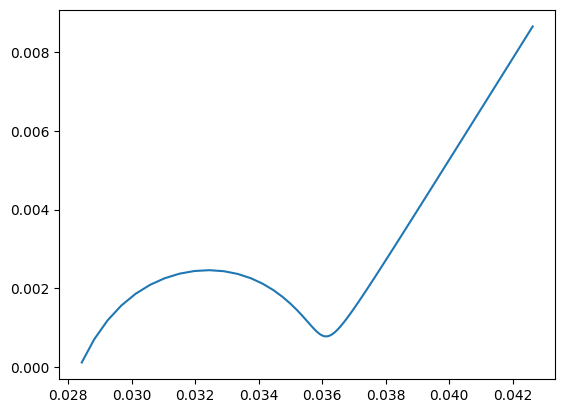

In [106]:
Z_W1 = wni_imp(ang_freq, opt_elems["A1"], opt_elems["a_w1"])
Z_cdl1 = cpe_imp(ang_freq, opt_elems["Q1"], opt_elems["alpha1"])
Z_L1 = i_imp(ang_freq, opt_elems["L1"])

Z_W2 = wni_imp(ang_freq, opt_elems["A2"], opt_elems["a_w2"])
Z_cdl2 = cpe_imp(ang_freq, opt_elems["Q2"], opt_elems["alpha2"])
Z_L2 = i_imp(ang_freq, opt_elems["L2"])

# Impedance from the Randles circuit 
def Z_randles(): 
    Z1 = Z_L1 + opt_elems["R_el1"] + 1/(1/(opt_elems["R_ct1"] + Z_W1) + 1/Z_cdl1)
    #Z2 = Z_L2 + opt_elems["R_el2"] + 1/(1/(opt_elems["R_ct2"]) + 1/Z_cdl2)
    Z2 =  1/(1/(opt_elems["R_ct2"]) + 1/Z_cdl2)
    Z = Z1 + Z2
    return Z  

plt.plot(Z_randles().real, -Z_randles().imag)
plt.show()

Comparing the experimental and the simulated EIS

(and also the ECM model)

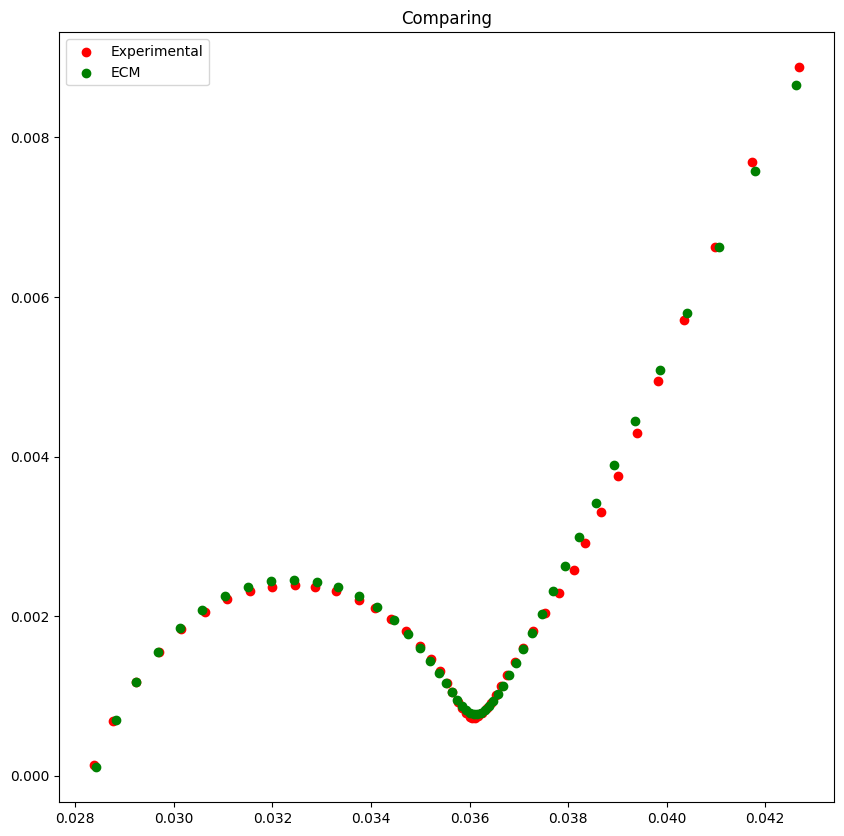

┌───────────────────────────────────────────────────────────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Parameter                                                 │ Type of parameter                                                                                                                                                                                           │
├───────────────────────────────────────────────────────────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ Positive electrode thickness [m]                          │ Parameter                                                                                                                             

In [107]:
names = ['Experimental', 'Simulation f domain', 'Simulation t domain']

fig, ax = plt.subplots(figsize=(10, 10)) 
ax.scatter(df_real, -df_imag, label=f"{names[0]}", color = 'red') 
ax.scatter(Z_randles().real, -Z_randles().imag, label = f'ECM', color = 'green')
#pybammeis.nyquist_plot(sim_f, ax=ax, linestyle="-", label=f"{names[1]}", alpha=0.7)
#pybammeis.nyquist_plot(impedances_time, ax=ax, linestyle="-", label=f"{names[2]}", alpha=0.7)

#ax.set_xlim(0.016, 0.045) 
#ax.set_ylim(0, 0.012)

plt.legend()
plt.title("Comparing") 
plt.show() 

model.print_parameter_info()
params.search("Surface area")


Bode plot for the experimental and simulated EIS

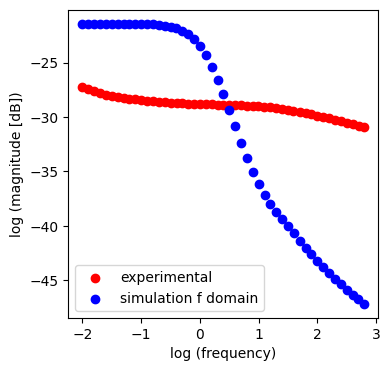

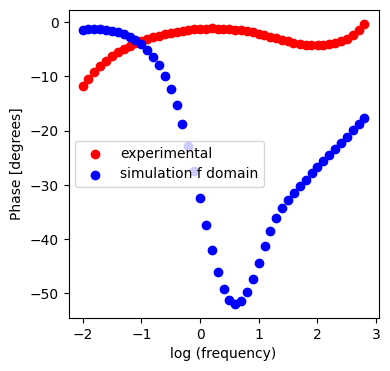

In [38]:
# Magnitude and phase of the simulated EIS: 
sim_f_mag = np.abs(sim_f)
#sim_t_mag = np.abs(impedances_time)

sim_f_phz = np.angle(sim_f)*180/np.pi # to convert to degrees 
#sim_t_phz = np.angle(impedances_time)*180/np.pi # to convert to degrees 

grense = 32
# Magnitude plot
fig, ax = plt.subplots(figsize=(4, 4)) 
ax.scatter(np.log10(freq), 20*np.log10(df_mag), color = 'red', label = 'experimental') 
ax.scatter(np.log10(frequencies), 20*np.log10(sim_f_mag), color = 'blue', label = 'simulation f domain') 
ax.set_xlabel('log (frequency)')
ax.set_ylabel('log (magnitude [dB])')
plt.legend()
plt.show() 

# Phase plot
fig, ax = plt.subplots(figsize=(4, 4)) 
ax.scatter(np.log10(freq), df_phz, color = 'red', label = 'experimental')
ax.scatter(np.log10(frequencies), sim_f_phz, color = 'blue', label = 'simulation f domain')
ax.set_xlabel('log (frequency)')
ax.set_ylabel('Phase [degrees]')
plt.legend()
plt.show() 


In [96]:
params.print_parameter_info()

AttributeError: 'ParameterValues' object has no attribute 'print_parameter_info'